# Temperatura externa y consumo de energía

Se modelará el consumo de energía de un edicifio a partir de la temperatura externa (_Outdoor Air Temperature (OAT)_) y otra información (ej. la hora del día) como variables predictivas en un algoritmo de regresión lineal.

In [1]:
#---  Librerías ---#
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy import stats

from sklearn.model_selection import train_test_split
import glob

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

## 1. Importar y organizar datos

Se utilizará el dataset correspondiente a _Long-term energy consumption & outdoor air temperature for 11 commercial buildings_ disponible en [OpenEI](https://openei.org/datasets/dataset/649aa6d3-2832-4978-bc6e-fa563568398e).

Solo se toman los 5 edificios cuyo set de datos está en estado _retail_ y, se une toda la información en un solo DataFrame.

In [2]:
#--- importamos los archivos ---#

# Especificamos el path de todos los archivos csv
all_files = glob.glob('building_data/*.csv')

li = []

# Importamos un df para cada path de archivo 
for file in all_files:
    #importamos usando la fecha como indice
    df = pd.read_csv(file, index_col=[0], parse_dates=True)
    li.append(df)

In [3]:
li[0].tail(10)

,OAT (F),Power (kW)
Timestamp,,
2010-12-30 21:45:00,48,284.1
2010-12-30 22:00:00,48,273.4
2010-12-30 22:15:00,48,196.7
2010-12-30 22:30:00,48,185.0
2010-12-30 22:45:00,48,163.1
2010-12-30 23:00:00,48,165.1
2010-12-30 23:15:00,48,157.6
2010-12-30 23:30:00,48,166.8
2010-12-30 23:45:00,48,164.0


In [4]:
li[0].shape

(34940, 2)

In [5]:
#--- concatenamos toda la información ---#
data = pd.concat(li, axis=0)

In [6]:
#--- vistazo a los datos ya concatenados ---#
data.sample(10)

,OAT (F),Power (kW)
Timestamp,,
2010-07-15 13:45:00,79,467.4
2010-10-12 14:15:00,90,340.0
2010-03-20 01:45:00,53,173.7
2010-07-20 18:15:00,90,382.8
2010-01-27 14:15:00,54,254.6
2010-04-27 02:30:00,45,152.3
2010-03-06 09:15:00,34,300.6
2010-12-16 06:30:00,39,179.6
2010-09-05 06:45:00,52,273.7


In [7]:
#--- Tamaño del set de datos ya concatenado ---#
data.shape

(174700, 2)

In [8]:
#--- Obteniendo caracteristicas de los indices (Timestamp) ---#
data.index[0].year

2010

Notemos entonces que la fuente de datos es pública, por lo cual __no hay conflictos de intereses__ a la hora de analizar estos datos. __No se requiere ningún permiso especial para el acceso, manipulación y discusión de resultados del presente notebook__. 

## 2. Exploración de los datos

Se realizará una indagación sobre la información obtenida y se buscará la mejor forma de limpiar el dataset disponible.

- Revisamos si hay valores faltantes.

In [9]:
# --- despliega la cantidad de valores faltantes por columna --- #
data.isnull().sum()

OAT (F)       0
Power (kW)    0
dtype: int64

- Hacemos un primer gráfico para ver como son los datos 

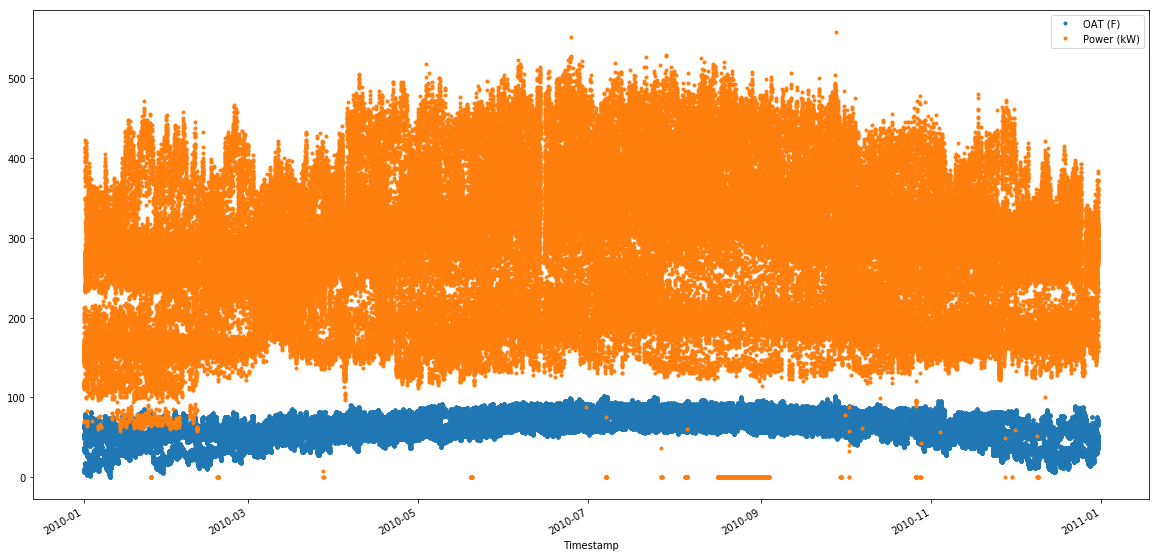

In [10]:
data.plot(figsize=(20,10), style='.')

A partir de este gráfico de dispersión podemos ver una región clara donde pertenecen los datos de _OAT_ y, en el caso de _Power_ hay un poco más de variación alrededor del área donde tienden los datos. 

- Hacemos un segundo gráfico para ver si hay un comportamiento estadistico claro, por ejemplo, una distribución gaussiana para los valores numéricos. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2821b38438>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2821289898>]], dtype=object)

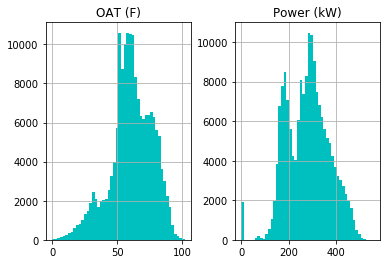

In [11]:
data.hist(color="c", bins=50)

De estos histograas podemos notar que, al juntar la infomación de varios edificios hay dos "picos" para el consumo de energía (Power kW). Mientras que, la temperatura externa OAT se mantiene con un comportamiento gaussiano de un solo pico muy marcado. 


## 3. Limpieza de los datos 

Realizaremos una copia de los datos originales y trabajaremos sobre dicho DataFrame de ahora en adelante, de esta manera se podrá volver a la información original en caso de aplicar un método no exitoso sobre los datos. 

In [12]:
# --- copiamos el conjunto de datos original --- #
dataset = data.copy()

Primero vamos a identificar si hay algún _Outlier_ en los datos que deba ser removido para mejorar el rendimiento de algún ajuste posterior. El siguiente análisis se realiza teniendo en cuenta las sugerencias en [towardsdatascience](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba).

- Realizamos un gráfico de caja (Box Plot) para la visualización de los _Outliers_


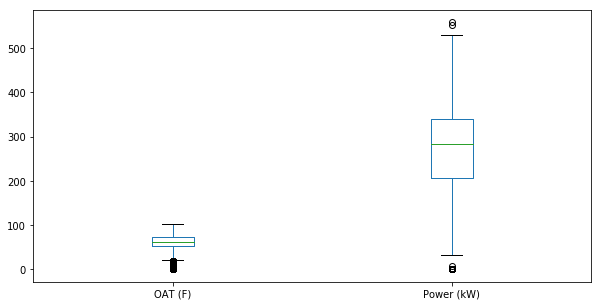

In [13]:
dataset.plot(kind='box', figsize=(10,5))

A partir del Box Plot podemos notar varias cosas: 
1. Los cuartiles están relativamente centrados con respecto a la variabilidad de los datos.
2. Hay varios puntos (datos) que no son agrupados dentro de los cuartiles, es decir, hay varios outliers tanto en _OAT (F)_ como en _Power (kW)_.

De esta manera, con el fin de remover los _Outliers_ identificados en el Box Plot, se propone usar el _IQR score_ para hacer nuestra limpieza de los datos. 

> El **rango intercuartil (IQR)** es una medida de dispersión estadistica la cual se calcula a partir de la diferencia entre los cuartiles superior e inferior (75vo y 25vo). $$ IQR = Q3 - Q1 $$ Esta medida es similar a la desviación estandar o a la varianza pero es mucho más robusta contra los _Ouliers_.


In [14]:
# --- calculamos los cuartiles y el IQR para nuestros datos --- #

Q1 = dataset.quantile(0.25)
Q3 = dataset.quantile(0.75)

IQR = Q3-Q1

print(IQR)

OAT (F)        21.000
Power (kW)    132.825
dtype: float64


- Separamos los datos de acuerdo al IQR. 

Se crea un nuevo df con los datos limpios

In [15]:
# --- df limpio --- #
clean_data = dataset[~((dataset < (Q1 - 1.1 * IQR)) |(dataset > (Q3 + 1.1 * IQR))).any(axis=1)]

In [16]:
clean_data.shape

(164537, 2)

Para visualizar los datos eliminados vamos a gráficar en un mismo plot los datos completos y los datos limpios.

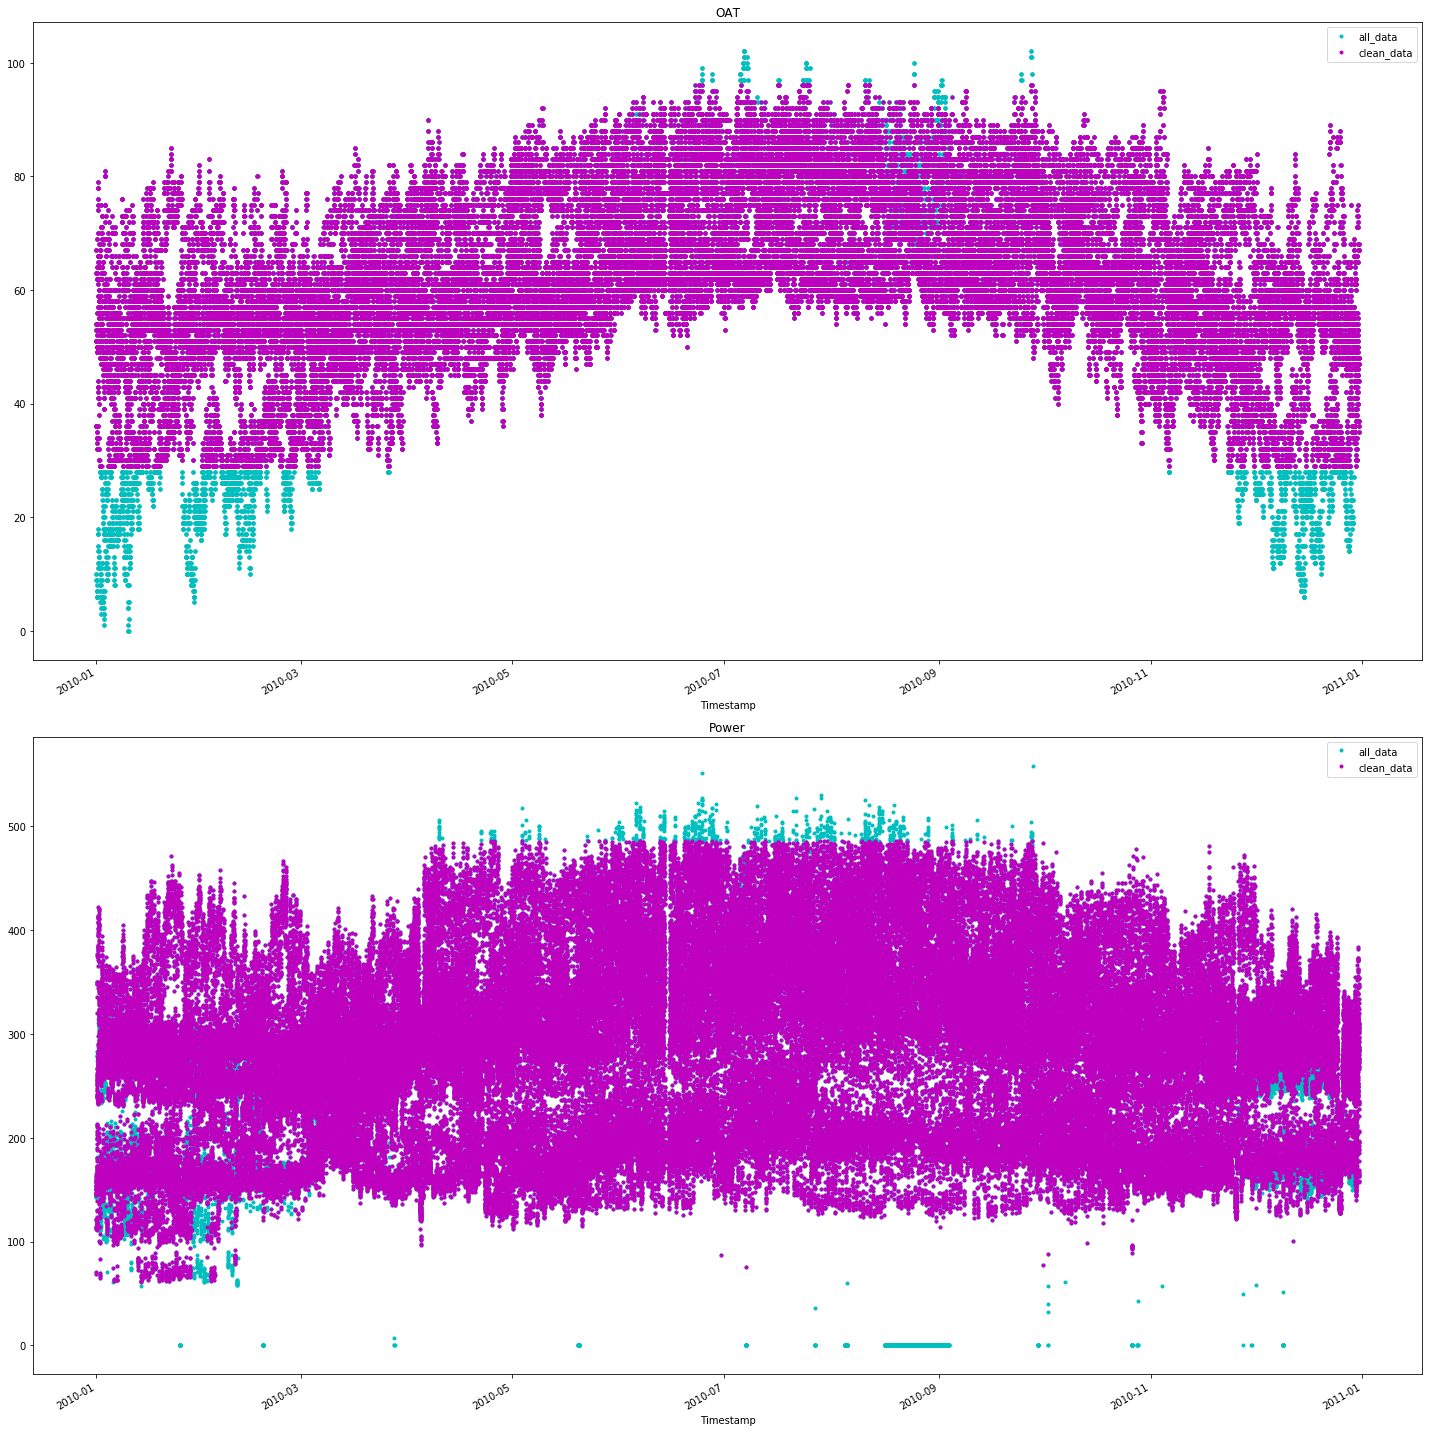

In [17]:
fig, [ax1, ax2] = plt.subplots(2, figsize=(20,20))

ax1.set_title('OAT')
data['OAT (F)'].plot(style='.', ax=ax1, label='all_data', color='c')
clean_data['OAT (F)'].plot(style='.', ax=ax1, label='clean_data', color='m')
ax1.legend()

ax2.set_title('Power')
data['Power (kW)'].plot(style='.', ax=ax2, label='all_data', color='c')
clean_data['Power (kW)'].plot(style='.', ax=ax2, label='clean_data', color='m')
ax2.legend()

plt.tight_layout()
plt.show()

Ya con los datos limpios, procedemos con el modelo de nuestro sistema.

## 4. Regresión Lineal

Realizaremos un primer modelo de regresión lineal para la variable de interés _OAT_. 

In [18]:
# ---  Realiza la regresion lineal ---#

# elije las variables 
X = pd.DataFrame(clean_data['OAT (F)'])
y = pd.DataFrame(clean_data['Power (kW)'])

# separa los set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=33)

# calcula la regresión lineal 
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)

# obtiene el score
print('score: ', linear_regression.score(X_test,y_test))

# obtiene los coeficientes 
print('coef: ', linear_regression.coef_)

# obtiene el intercepto
print('intercept: ', linear_regression.intercept_)

score:  0.352897360077
coef:  [[ 3.54070346]]
intercept:  [ 63.64123606]


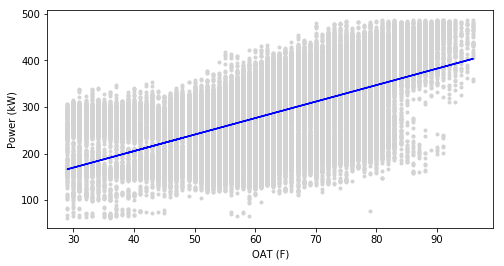

In [19]:
# --- visualizando el modelo --- #
y_pred = linear_regression.intercept_[0] + linear_regression.coef_[0][0] * X_test.values.flatten()

plt.figure(figsize=(8,4))
# dibujar los datos
plt.plot(X_test.values.flatten(),y_test.values.flatten(),'.', color='lightgray')
# dibujar recta estimada
plt.plot(X_test.values.flatten(), y_pred, '-b')

plt.xlabel('OAT (F)')
plt.ylabel('Power (kW)')

plt.show()

A partir de este primer modelo empezaremos a hacer un aumento de las caracteristicas para la regresión lineal con el fin de encontrar el mejor modelo posible. 

## 5. Adición de caracteristicas 

Consideramos agregar una diferenciación temporal de acuerdo a la hora del día para cada una de las medidas pues, de acuerdo a la discusión realizada en clase, este dato aporta información importante al sistema.

In [20]:
#--- copiamos el data set limpio para trabajar en él a partir de acá ---#

nw_data = clean_data.copy()

- Agregamos una columna que contenga la información de la hora del día 

In [21]:
nw_data['hour'] = nw_data.index.hour

In [22]:
nw_data.head()

,OAT (F),Power (kW),hour
Timestamp,,,
2010-01-12 13:15:00,29,278.2,13
2010-01-12 13:30:00,29,276.5,13
2010-01-12 13:45:00,29,277.0,13
2010-01-12 14:00:00,29,277.2,14
2010-01-12 14:15:00,31,278.2,14


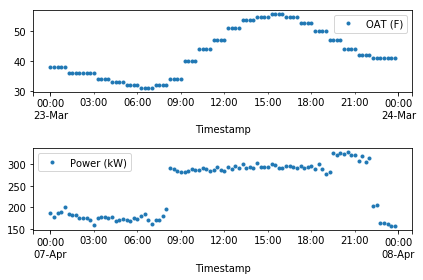

In [23]:
#--- Visualizamos datos en función de la hora ---#

fig, axs = plt.subplots(2)
nw_data.loc['2010-03-23', ['OAT (F)']][:96].plot(ax=axs[0], style='.')
nw_data.loc['2010-04-07', ['Power (kW)']][:96].plot(ax=axs[1], style='.')

plt.tight_layout()
plt.show()

A partir de la visualización podemos notar algunas tendencias en términos de la hora. Primero que la temperatura suele permanecer muy baja en horas de la madrugada y, empieza a decender despues de las 6pm cuando llega la noche. Segundo, el uso de energía es aproximadamente estable durante horas laborales, lo cual tiene sentido pues estamos hablando de edificios comerciales.

Por todo lo anterior, se propone entonces incluir dos variables cualitativas con respecto al momento del día, las cuales serán: _commercial hours_ en el rango $[09:00, 21:00]$ y, _sunlight hours_ en el rango $[06:00, 18:00]$. 

- Agregamos columna _commercial hours_. Esta corresponde al horario habitual de funcionamiento de los negocios comerciales el cual está entre las 9am y las 9pm aproximadamente. 

La columna tendrá valor 1 para las horas de funcionamiento y 0 para las horas de no trabajo. 

In [24]:
# --- agregamos columna comercial hours --- #
nw_data['commercial hours'] = np.where( ((nw_data.index.hour >= 9) & (nw_data.index.hour <= 21)), 1, 0) 

- Agregamos la _sunlight hours_. Esta corresponde a las horas donde la superficie del edificio recibe radiación solar. El horario sugerido es entre las 6am y las 6pm. 

La columna tendrá valor 1 para las horas con sol y valor 0 para todas las demás.

In [25]:
# --- agregamos columna comercial hours --- #
nw_data['sunlight hours'] = np.where( ((nw_data.index.hour >= 6) & (nw_data.index.hour <= 18)), 1, 0) 

In [26]:
nw_data.sample(10)

,OAT (F),Power (kW),hour,commercial hours,sunlight hours
Timestamp,,,,,
2010-09-12 16:30:00,72,314.5,16,1,1
2010-01-28 11:00:00,40,240.3,11,1,1
2010-04-19 21:30:00,61,335.8,21,1,0
2010-08-29 02:15:00,83,221.9,2,0,0
2010-10-18 05:30:00,67,226.7,5,0,0
2010-09-08 19:15:00,83,432.3,19,1,0
2010-08-28 14:45:00,68,362.6,14,1,1
2010-07-29 19:15:00,63,372.7,19,1,0
2010-09-01 18:30:00,61,368.5,18,1,1


## 6. Modelo con nuevas caracteristicas 

Se presentan todos los modelos resultantes de las nuevas caracteristicas para evaluar cual es el mejor modelo de acuerdo al score.

In [27]:
# ---  Realiza la regresion lineal ---#

# elije las variables 
X = pd.DataFrame(nw_data[['OAT (F)', 'commercial hours']])
y = pd.DataFrame(nw_data['Power (kW)'])

# separa los set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=33)

# calcula la regresión lineal 
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)

print("Modelo adicionando commercial hours")

# obtiene el score
print('score: ', linear_regression.score(X_test,y_test))

# obtiene los coeficientes 
print('coef: ', linear_regression.coef_)

# obtiene el intercepto
print('intercept: ', linear_regression.intercept_)

Modelo adicionando commercial hours
score:  0.647730771711
coef:  [[  2.81316972  93.34962561]]
intercept:  [ 58.26633577]


In [28]:
# ---  Realiza la regresion lineal ---#

# elije las variables 
X = pd.DataFrame(nw_data[['OAT (F)', 'commercial hours', 'sunlight hours']])
y = pd.DataFrame(nw_data['Power (kW)'])

# separa los set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=33)

# calcula la regresión lineal 
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)

print("Modelo adicionando commercial hours y sunlight hours")

# obtiene el score
print('score: ', linear_regression.score(X_test,y_test))

# obtiene los coeficientes 
print('coef: ', linear_regression.coef_)

# obtiene el intercepto
print('intercept: ', linear_regression.intercept_)

Modelo adicionando commercial hours y sunlight hours
score:  0.647900404477
coef:  [[  2.81478514  94.50788718  -2.34017978]]
intercept:  [ 58.80301653]


In [29]:
# ---  Realiza la regresion lineal ---#

# elije las variables 
X = pd.DataFrame(nw_data[['OAT (F)', 'hour','commercial hours', 'sunlight hours']])
y = pd.DataFrame(nw_data['Power (kW)'])

# separa los set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=33)

# calcula la regresión lineal 
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)

print("Modelo adicionando hour, commercial hours y sunlight hours")

# obtiene el score
print('score: ', linear_regression.score(X_test,y_test))

# obtiene los coeficientes 
print('coef: ', linear_regression.coef_)

# obtiene el intercepto
print('intercept: ', linear_regression.intercept_)

Modelo adicionando hour, commercial hours y sunlight hours
score:  0.707366599523
coef:  [[  2.76102048   3.71737503  59.78376127  11.13744522]]
intercept:  [ 30.88926218]


In [30]:
# ---  Realiza la regresion lineal ---#

# elije las variables 
X = pd.DataFrame(nw_data[['OAT (F)', 'hour','commercial hours']])
y = pd.DataFrame(nw_data['Power (kW)'])

# separa los set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=33)

# calcula la regresión lineal 
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)

print("Modelo adicionando hour y commercial hours")

# obtiene el score
print('score: ', linear_regression.score(X_test,y_test))

# obtiene los coeficientes 
print('coef: ', linear_regression.coef_)

# obtiene el intercepto
print('intercept: ', linear_regression.intercept_)

Modelo adicionando hour y commercial hours
score:  0.704480911961
coef:  [[  2.77139462   3.49280336  66.99093635]]
intercept:  [ 34.9430318]


## 7. Modelo elegido

De acuerdo a lo discutido en clase, el mejor modelo sigue siendo aquel que incluye la hora del día y las horas donde el comercio suele estar abierto. Además, se comprueba que la variable _sunlight hours_ sugerida no aporta información al modelo

In [31]:
# ---  Realiza la regresion lineal ---#

# elije las variables 
X = pd.DataFrame(nw_data[['OAT (F)', 'hour','commercial hours']])
y = pd.DataFrame(nw_data['Power (kW)'])

# separa los set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=33)

# calcula la regresión lineal 
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)

print("Modelo más optimo")

# obtiene el score
print('score: ', linear_regression.score(X_test,y_test))

# obtiene los coeficientes 
print('coef: ', linear_regression.coef_)

# obtiene el intercepto
print('intercept: ', linear_regression.intercept_)

Modelo más optimo
score:  0.704480911961
coef:  [[  2.77139462   3.49280336  66.99093635]]
intercept:  [ 34.9430318]


El puntaje de este **modelo mejorado es** $0.704$, lo que es significativamente más alto que el score del **modelo inicial** el cual era $0.352$. Así pues, podemos notar que la adición de caracteristicas como la hora del día y las horas de apertura comercial aporta información significativa al modelo realizado. 